# Configuração do Ambiente
Nesta seção, importaremos as bibliotecas necessárias e configuraremos o ambiente para o projeto.

In [1]:

# Importações necessárias para o projeto
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Verifica se o CUDA está disponível e define o dispositivo para GPU, se possível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Carregamento e Preparação dos Dados
Aqui, carregaremos o conjunto de dados MNIST e o prepararemos para o processo de treinamento.

In [2]:
# Definindo uma transformação para pré-processar os dados: Convertendo as imagens em tensores e normalizando-os
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Carregando o conjunto de dados MNIST
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Criando DataLoaders para treinamento e teste
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 9708677.24it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68322444.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 2401507.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3958962.75it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Construção do Autoencoder
Nesta seção, definiremos a arquitetura do nosso autoencoder.

In [3]:
# Definindo a arquitetura do Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # representação codificada é um vetor de dimensão 3
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()  # saída é uma imagem de 28x28, então usamos Tanh para manter os valores entre -1 e 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Treinamento do Autoencoder
Aqui, treinaremos nosso autoencoder com o conjunto de dados MNIST.

In [4]:

# Instanciando o autoencoder e definindo a função de perda e otimizador
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

# Número de épocas para treinar o autoencoder
num_epochs = 20

# Listas para manter o registro das perdas
train_losses = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)  # achatar a imagem
        # forward
        output = autoencoder(img)
        loss = criterion(output, img)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Registro da perda de treinamento
    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Treinamento concluído.')


Epoch [1/20], Loss: 0.1694
Epoch [2/20], Loss: 0.1415
Epoch [3/20], Loss: 0.1549
Epoch [4/20], Loss: 0.1357
Epoch [5/20], Loss: 0.1322
Epoch [6/20], Loss: 0.1380
Epoch [7/20], Loss: 0.1316
Epoch [8/20], Loss: 0.1357
Epoch [9/20], Loss: 0.1400
Epoch [10/20], Loss: 0.1236
Epoch [11/20], Loss: 0.1195
Epoch [12/20], Loss: 0.1292
Epoch [13/20], Loss: 0.1244
Epoch [14/20], Loss: 0.1597
Epoch [15/20], Loss: 0.1288
Epoch [16/20], Loss: 0.1250
Epoch [17/20], Loss: 0.1405
Epoch [18/20], Loss: 0.1449
Epoch [19/20], Loss: 0.1251
Epoch [20/20], Loss: 0.1351
Treinamento concluído.


# Extração de Embeddings
Nesta seção, utilizaremos o modelo treinado para obter embeddings dos dados MNIST.

In [5]:

# Função para extrair embeddings usando o codificador do autoencoder
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = []
        labels = []
        for batch in dataloader:
            img, label = batch
            img = img.to(device)
            img = img.view(img.size(0), -1)
            embedding = model.encoder(img)  # passa a imagem pelo codificador
            embeddings.append(embedding.cpu().numpy())
            labels.append(label.numpy())
            
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

# Extração dos embeddings
train_embeddings, train_labels = extract_embeddings(train_loader, autoencoder)
print("Embeddings extraídos.")


Embeddings extraídos.


# Redução de Dimensionalidade com t-SNE
Aqui, aplicaremos o t-SNE para reduzir a dimensionalidade dos embeddings para 2D.

In [6]:

# Aplicando t-SNE nos embeddings
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(train_embeddings)

print("t-SNE aplicado nos embeddings.")


t-SNE aplicado nos embeddings.


# Visualização
Finalmente, visualizaremos os dados 2D para compreender as similaridades entre diferentes classes no MNIST.

In [8]:
embeddings_tsne.shape

(60000, 2)

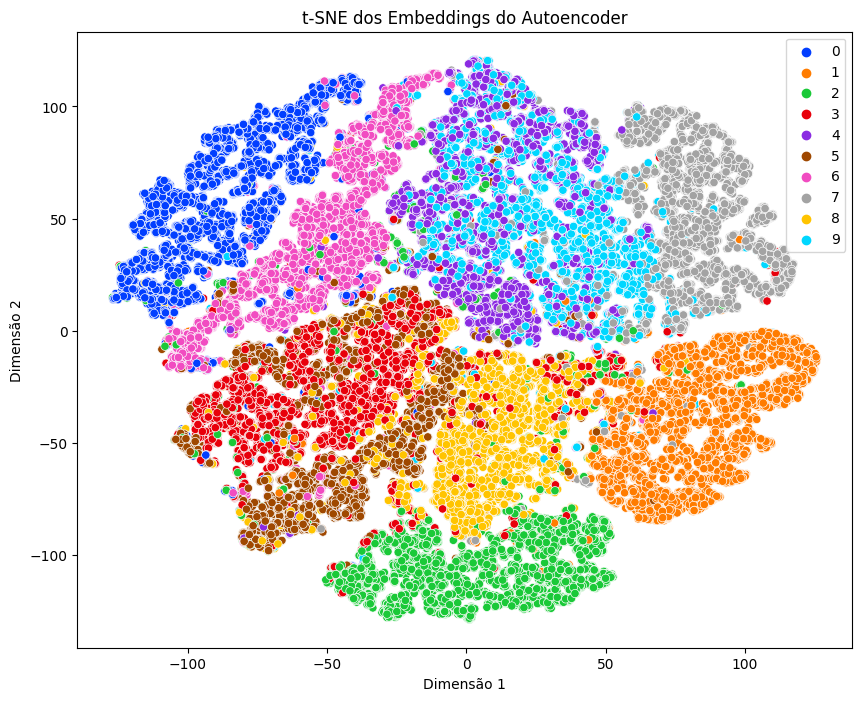

In [9]:

# Criando um gráfico de dispersão dos embeddings 2D
plt.figure(figsize=(10, 8))
palette = sns.color_palette("bright", 10)

# Plotando os embeddings. Cada classe (dígito) será representada por uma cor diferente
sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=train_labels,
                legend='full', palette=palette)

plt.title('t-SNE dos Embeddings do Autoencoder')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()
